In [14]:
###################################################################################################
#
# Copyright (C) 2022 Maxim Integrated Products, Inc. All Rights Reserved.
#
# Maxim Integrated Products, Inc. Default Copyright Notice:
# https://www.maximintegrated.com/en/aboutus/legal/copyrights.html
#
###################################################################################################

## IMPORTS
import os
import sys
import datetime
import time

import importlib
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from pathlib import Path
from collections import OrderedDict

import distiller

## FOR TENSOR BOARD
try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

## PATH FOR MODELS AND DATASET
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'models'))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'datasets'))

from unetnilm.metrics import get_results_summary, example_f1_score
from datasets import nilm2
import ai8x
mod = importlib.import_module("ai85net-nilm-seq2point")

%matplotlib inline

msglogger = None

In [15]:
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "../data"
classes =  ['fridge', 'washer dryer', 'kettle', 'dish washer', 'microwave']
simulate = False
batch_size = 1
args = Args(act_mode_8bit=True)
transform = transforms.Compose([
                        ai8x.normalize(args=args)
        ])

ai8x.set_device(device=85, simulate=simulate, round_avg=True)

dataset = nilm2.NILM(root=data_dir,
                     classes=classes,
                     d_type='train',
                     t_type='ukdale',
                     transform=transform,
                     download=False,
                     seq_len = 100)

Configuring device: MAX78000, simulate=False.


In [17]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [77]:
dl_iter = iter(dataloader)
samples = 1000

saved = []

for j in range(10000):
        next(dl_iter)

for i in range(samples):
        dl = next(dl_iter)
        saved.append(dl)

In [81]:
# figs, axes = plt.subplots(samples, figsize=(10, 15))

saved_states = []

for y, (inputs, target_state) in enumerate(saved):
    inp = np.array(inputs.squeeze(0)).T
    # axes[y].plot(inp)
    saved_states.append(np.array(target_state))

In [79]:
stacked_states = np.vstack(saved_states)

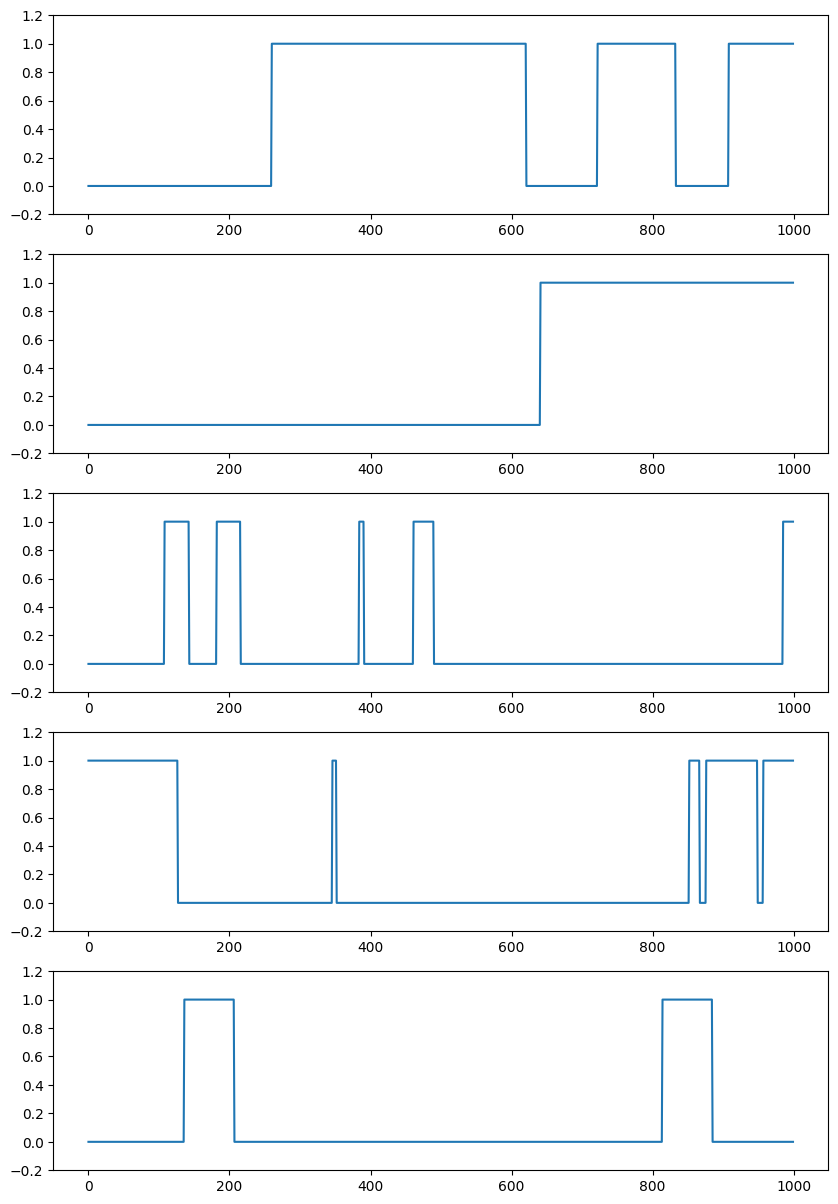

In [80]:
state_fig, state_axes = plt.subplots(5, figsize=(10, 15))

for i in range(5):
    state_axes[i].plot(stacked_states[:,i])
    state_axes[i].set_ylim([-0.2, 1.2])